In [58]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as fun
import numpy as np
import pandas as pd

# Load do dataset

In [59]:
from lib.data import load_dataset

rs = 2

x_train, y_train, x_valid, y_valid = load_dataset('dts/dts_all/train.csv',rs=rs)
x_test = load_dataset('dts/dts_all/test.csv',test_only=True,rs=rs)

# Normalização

In [60]:
from sklearn.preprocessing import StandardScaler
from my_nn import dts

sc = StandardScaler()
sc.fit(x_train.values)

x_train = sc.transform(x_train.values)
x_valid = sc.transform(x_valid.values)
x_test = sc.transform(x_test.values)

# Feature Selection

In [61]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

selec_mod = SelectFromModel(estimator=LogisticRegression(random_state=rs, max_iter=2000)).fit(x_train, y_train)

x_train = selec_mod.transform(x_train)
x_valid = selec_mod.transform(x_valid)
x_test = selec_mod.transform(x_test)

# Dataloaders

In [62]:
from torch.utils.data import DataLoader
train_dts = dts(x_train,y_train)
valid_dts = dts(x_valid,y_valid)

training_loader = DataLoader(train_dts, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dts, batch_size=32, shuffle=True)

In [63]:
from my_nn import nnModel

model = nnModel(inFeatures = x_train.shape[1], random_state=2)

losses, accs = model.fit(
    trainloader=training_loader,
    validloader=valid_loader,
    learningRate=0.02,
    momentum=0.9,
    gamma=0.97,
    numEpochs=31,
    verbose=False
)

[312.45046747103333, 146.3804355347529, 99.53605472203344, 75.91588069300633, 60.68885351822246, 47.866313302889466, 38.16036359866848, 35.58739619838889, 26.845565224910388, 25.64759323683802, 19.857772838171968, 14.666169076439473, 12.777543654346346, 14.065464121275, 7.336341283657362, 4.473896073881221, 3.447044642880087, 4.211338469924971, 3.2704007361602194, 3.224675486481834, 3.206148271028427, 3.196826141794748, 3.188844913213927, 3.1830965483345643, 3.1785050996890267, 3.174818613615855, 3.171909066829631, 3.169045571873131, 3.1669772158795775, 3.1649178277803376, 3.163189231976932]
[96.6875, 96.9625, 98.05, 98.2625, 98.2375, 98.2375]


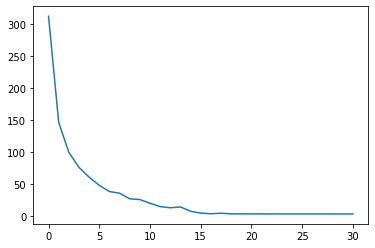

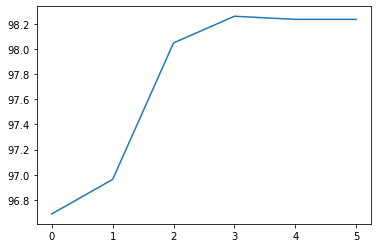

In [64]:
print(losses)
print(accs)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(losses)
plt.figure()
plt.plot(accs)

In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

yvalid = model.predict(torch.tensor(x_valid, dtype=torch.float32))

print("Acc: {:.3f}".format(accuracy_score(y_true=y_valid, y_pred=yvalid)))
print("ROC: {:.3f}".format(roc_auc_score(y_valid, yvalid)))
print("Acc: {:.3f}".format(precision_score(y_true=y_valid, y_pred=yvalid)))
print("Acc: {:.3f}".format(recall_score(y_true=y_valid, y_pred=yvalid)))

Acc: 0.983
ROC: 0.982
Acc: 0.986
Acc: 0.978


In [66]:
ypred = model.predict(torch.tensor(x_test, dtype=torch.float32))
import pandas as pd
result = pd.DataFrame(data={
        "Id": range(len(ypred)),
        "Category": ypred.astype(int)
    }, index=None)

result.to_csv("result.csv", index=None)